# Baseline Experiment (KRR Model)

In [13]:
import numpy as np
from formatData import loadData
from qml.kernels import gaussian_kernel, matern_kernel
from qml.math import cho_solve
from utils import unison_shuffle
from sklearn.model_selection import train_test_split
from gan import GenAdvNetwork
import tensorflow as tf
from utils import random_generator

### Loading Data

In [14]:
"""
Loading data
Note than we can only specify absolute location of the raw data
"""
molRep2D, energies = loadData(12, "/home/panthibivek/thesis/GAN_pkg/data/traj.xyz")
#randomize the data and split it into training and test set
# unison_shuffle(molRep2D, energies)
# X_train, X_test, y_train, y_test = train_test_split(molRep2D,energies,
#                                    random_state=104, 
#                                    test_size=0.1, 
#                                    shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(molRep2D,energies,
                                   test_size=0.1)

print("Training data size:", X_train.shape)
print("Test data size:", X_test.shape)

input data size: (10000, 78)
output data size: (10000,)
Training data size: (9000, 78)
Test data size: (1000, 78)


### Running Regression for a range of Sigma

In [15]:
"""
Regression
"""
def regression(X : np.array, Y : np.array, sigma : float, lambda_ : float):
    # K = gaussian_kernel(X_train, X_train, sigma)
    K = matern_kernel(X, X, sigma, order=0, metric='l2')
    K[np.diag_indices_from(K)] += lambda_
    alpha = cho_solve(K, Y)
    return alpha

"""
Prediction
"""
def prediction(X : np.array, Xtest : np.array, sigma : float, alpha_ : np.array):
    Ks = matern_kernel(Xtest, X, sigma, order=0, metric='l2')
    Y_predicted = np.dot(Ks, alpha_)
    return Y_predicted
    
sigmaArr = [float(i) for i in range(50, 250, 50)] + [
    float(i) for i in range(250, 1000, 250)] + [
    float(i) for i in range(1000, 3000, 1000)]
lambda_ = 1e-8
mean_abs_errors = []
for sigma_ in sigmaArr:
    temp_alpha = regression(X_train, y_train, sigma_, lambda_)
    Y_predicted = prediction(X_train, X_test, sigma_, temp_alpha)
    mean_abs_e = np.mean(np.abs(Y_predicted - y_test))
    if sigma_ == sigmaArr[0] or mean_abs_e < best_mae:
        argmax_sigma = sigma_
        best_alpha = temp_alpha
        best_mae = mean_abs_e
    mean_abs_errors.append(mean_abs_e)
mae_arr = np.array(mean_abs_errors)

In [16]:
print("Lowest Mean Absolute Error is",mean_abs_e, "when sigma is",argmax_sigma)

Lowest Mean Absolute Error is 0.003423644536108789 when sigma is 1000.0


### Graph of Sigma vs MAE

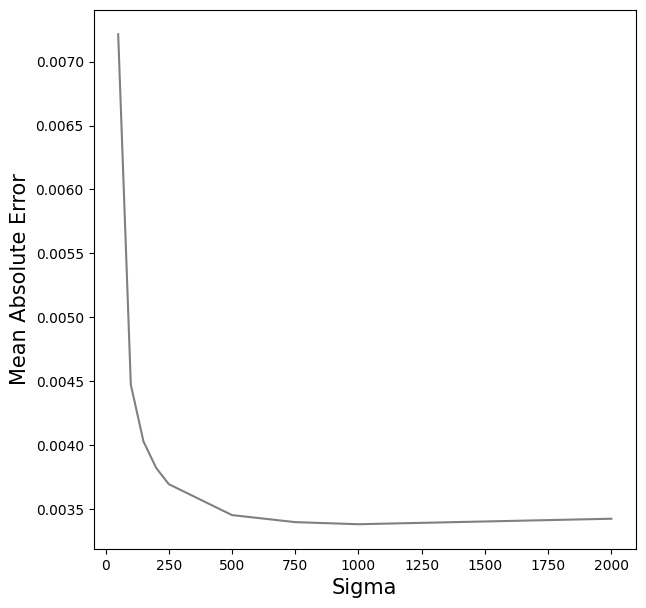

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))
plt.plot(sigmaArr, mae_arr, c="gray")
plt.xlabel('Sigma', fontsize=15)
plt.ylabel('Mean Absolute Error', fontsize=15)
fig1 = plt.gcf()
plt.show()
fig1.savefig('sigma_vs_MAE.png', dpi = 300)

In [18]:
training_sample_sizes = [100] + [int(i) for i in range(500, 10000, 500)]
lambda_ = 1e-8
mean_abs_errors_list = []
for sample_size in training_sample_sizes:
    temp_alpha = regression(X_train[:sample_size], y_train[:sample_size], argmax_sigma, lambda_)
    Y_predicted = prediction(X_train[:sample_size], X_test, argmax_sigma, temp_alpha)
    mean_abs_e = np.mean(np.abs(Y_predicted - y_test))
    mean_abs_errors_list.append(mean_abs_e)

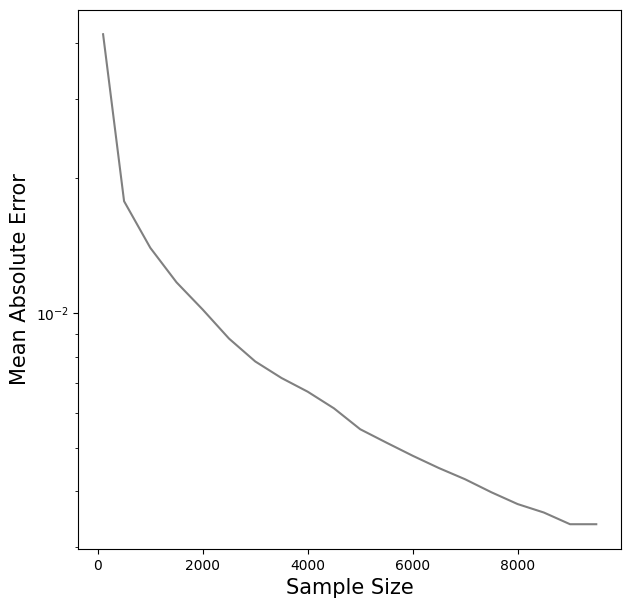

In [32]:
plt.figure(figsize=(7,7))
plt.plot(training_sample_sizes, mean_abs_errors_list, c="gray")
plt.xlabel('Sample Size', fontsize=15)
plt.ylabel('Mean Absolute Error', fontsize=15)
plt.yscale('log')
fig2 = plt.gcf()
plt.show()
fig2.savefig('sampleSize_vs_MAE.png', dpi = 300)

### Best Regression

In [20]:
"""
Best Prediction
"""
Ks = matern_kernel(X_test, X_train, argmax_sigma, order=0, metric='l2')
Y_predicted = np.dot(Ks, best_alpha)

### Graph of Real vs Predicted Values

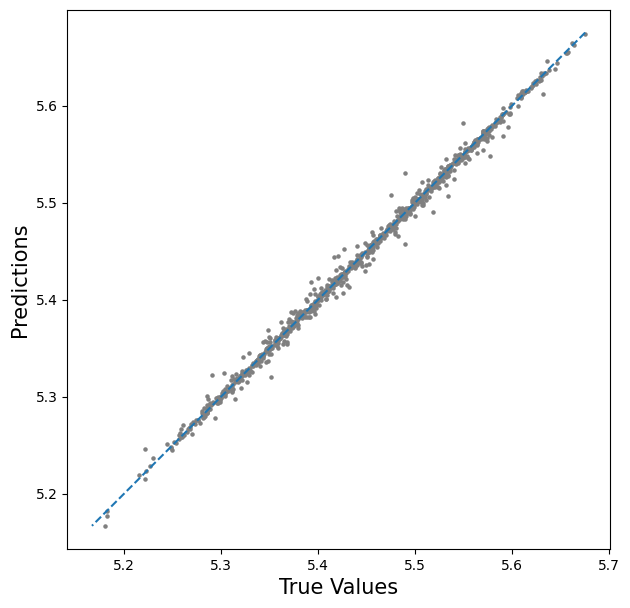

In [21]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))
plt.scatter(y_test, Y_predicted, c="gray", s=5)

p1 = max(max(Y_predicted), max(y_test))
p2 = min(min(Y_predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], '--')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
fig2 = plt.gcf()
plt.show()
fig2.savefig('actual_vs_prediction.png', dpi = 300)

### Generating samples from GAN 

In [22]:
latent_dim_ = 78
batch_size_ = 32
weights_path = "/home/panthibivek/thesis/GAN_pkg/runs/train/exp2/weights/"
GanModel = GenAdvNetwork(latent_dim=latent_dim_, batch_size=batch_size_)
GanModel.compile(
    generator_opt=tf.keras.optimizers.Adam(learning_rate=0.001),
    discriminator_opt=tf.keras.optimizers.Adam(learning_rate=0.001),
    disc_loss=tf.keras.losses.BinaryCrossentropy(),
    gen_loss=tf.keras.losses.MAE
)

random_data = random_generator((1, latent_dim_))

GanModel.generator(random_data)
GanModel.load_weights(weights_path) 

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 13)                1027      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 13)                0         
                                                                 
 reshape_1 (Reshape)         (None, 13, 1)             0         
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 39, 128)          640       
 ranspose)                                                       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 39, 128)           0         
                                                                 
 batch_normalization_3 (Batc  (None, 39, 128)          512       
 hNormalization)                                         

In [23]:
random_data_ = random_generator((10000, latent_dim_))
generated_output = GanModel.generator(random_data_)
generated_columb1D_arr = generated_output.numpy()

In [27]:
def energyPrediction(sigma : float, alpha_ : np.array):
    Ks = matern_kernel(generated_columb1D_arr, X_train, sigma, order=0, metric='l1')
    Y_predicted = np.dot(Ks, alpha_)
    return Y_predicted

lambda_ = 1e-8
# alpha = regression(argmax_sigma, lambda_)
# predicted_energies = energyPrediction(argmax_sigma, alpha)
temp_alpha = regression(X_train, y_train, argmax_sigma, lambda_)
predicted_energies = prediction(X_train, generated_columb1D_arr, argmax_sigma, temp_alpha)
# print(predicted_energies)

### Histogram of Energies (Training data)

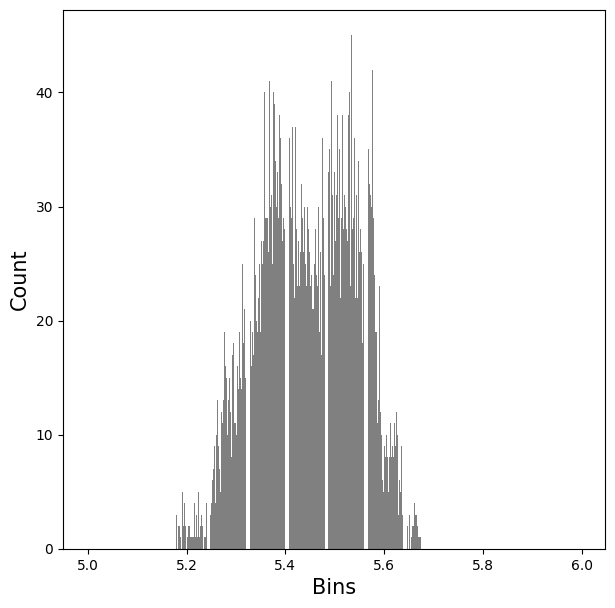

In [28]:
plt.figure(figsize=(7,7))
bins_ = np.arange(5.000000, 6.000000, 0.001000)
plt.hist(y_train, bins=bins_, color="gray", align='left', rwidth=0.9)
plt.xlabel('Bins', fontsize=15)
plt.ylabel('Count', fontsize=15)
fig1 = plt.gcf()
plt.show()
fig1.savefig('training_energy_distribution.png', dpi = 300)

### Histogram of Energies (GAN generated data)

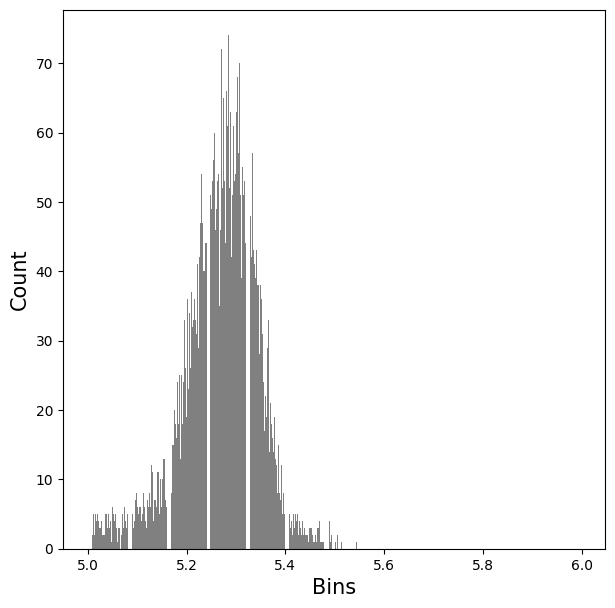

In [30]:
plt.figure(figsize=(7,7))
bins_ = np.arange(5.000000, 6.000000, 0.001000)
plt.hist(predicted_energies, bins=bins_, color="gray", align='left', rwidth=0.9)
plt.xlabel('Bins', fontsize=15)
plt.ylabel('Count', fontsize=15)
fig1 = plt.gcf()
plt.show()
fig1.savefig('generated_energy_distribution.png', dpi = 300)